# Preprocessing

## download data

In [1]:
# run this cell to download data!

import os

directory_path = "data/00--raw/macro"

if not os.path.exists(directory_path) or not os.listdir(directory_path):
    !python3 -m src.fetch.pipeline


2025-04-25 22:11:23,869 - [pipeline.py    ] - [START]   - Running build_indicators_json.py...
2025-04-25 22:11:23,873 - [build_indicator] - [SUCCESS] - indicators.json saved to: data/10--metadata
2025-04-25 22:11:23,873 - [pipeline.py    ] - [SUCCESS] - build_indicators_json.py completed successfully.
2025-04-25 22:11:23,873 - [pipeline.py    ] - [START]   - Running build_countries_json.py...
2025-04-25 22:11:23,876 - [build_countries] - [SUCCESS] - countries.json saved to: data/10--metadata
2025-04-25 22:11:23,877 - [pipeline.py    ] - [SUCCESS] - build_countries_json.py completed successfully.
2025-04-25 22:11:23,877 - [pipeline.py    ] - [START]   - Running build_categories_json.py...
2025-04-25 22:11:23,878 - [build_categorie] - [SUCCESS] - categories.json saved to: data/10--metadata
2025-04-25 22:11:23,878 - [pipeline.py    ] - [SUCCESS] - build_categories_json.py completed successfully.
2025-04-25 22:11:23,878 - [pipeline.py    ] - [START]   - Running download_macro.py...
2025-04

In [2]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset()

result_data = dataset.get(result_data)


In [3]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

research_and_development_expenditure_percent_of_gdp
individuals_using_the_internet_percent_of_population
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
area
education_expenditures
education_years
services_value_added_percent_of_gdp
manufacturing_value_added_percent_of_gdp
net_official_development_assistance_received_current_usd
total_population
poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population
economic_activity
life_expectancy_at_birth_total_years
gdp_per_person_employed_constant_2011_ppp_usd
population_size
gini_income_inequality
petroleum_energy_production
renewables_excluding_hydro_share
energy_use_kg_of_oil_equivalent_per_capita
hydro_electric_energy_production
gas_energy_production
coal_energy_production
consumer_price_index_change
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [4]:
import numpy as np
import pandas as pd
from typing import Dict, Any

def health_check_datadict(datadict: Dict[str, pd.DataFrame]) -> Dict[str, Any]:
    """
    Runs a suite of checks on your dict of DataFrames.

    Returns a dict containing:
      - start_dates, end_dates: per-feature min/max index
      - columns: set of columns per feature
      - index_dtype: inferred dtype of each index
      - duplicate_index: count of duplicate index entries per feature
      - duplicate_columns: count of duplicate column names per feature
      - non_numeric: count of entries that aren’t int/float/NaN
      - summary: high-level pass/fail for the first two checks
    """
    results = {
        "start_dates": {},
        "end_dates": {},
        "columns": {},
        "index_dtype": {},
        "duplicate_index": {},
        "duplicate_columns": {},
        "non_numeric": {},
        "summary": {}
    }

    # 1) Gather per‐feature stats
    for feature, df in datadict.items():
        # — ensure index is datetime if possible
        idx = df.index
        if not pd.api.types.is_datetime64_any_dtype(idx):
            try:
                idx = pd.to_datetime(idx, errors="raise", format="%Y")
                results["index_dtype"][feature] = "datetime (year)"
            except Exception:
                results["index_dtype"][feature] = f"{type(idx).__name__}"
        else:
            results["index_dtype"][feature] = "datetime"

        # record start / end
        results["start_dates"][feature] = idx.min()
        results["end_dates"][feature]   = idx.max()

        # record column set
        colset = set(df.columns)
        results["columns"][feature] = colset

        # duplicate checks
        results["duplicate_index"][feature]   = int(idx.duplicated().sum())
        results["duplicate_columns"][feature] = int(df.columns.duplicated().sum())

        # non‐numeric checks
        # anything that is not NaN and not an int/float
        def _is_bad(x):
            return not (pd.isna(x) or isinstance(x, (int, float, np.floating, np.integer)))
        bad_count = df.map(_is_bad).sum().sum()
        results["non_numeric"][feature] = int(bad_count)

    # 2) Summary for uniformity
    unique_starts = set(results["start_dates"].values())
    unique_ends   = set(results["end_dates"].values())
    all_cols      = list(results["columns"].values())

    same_dates = (len(unique_starts) == 1 and len(unique_ends) == 1)
    same_cols  = all(colset == all_cols[0] for colset in all_cols)

    results["summary"]["uniform_start_end"]   = same_dates
    results["summary"]["uniform_columns"]     = same_cols
    if not same_dates:
        results["summary"]["mismatched_starts"] = unique_starts
        results["summary"]["mismatched_ends"]   = unique_ends
    if not same_cols:
        # show which features differ
        common = set.intersection(*all_cols)
        results["summary"]["extra_columns"]   = {
            f: results["columns"][f] - common for f in datadict
        }
        results["summary"]["missing_columns"] = {
            f: common - results["columns"][f] for f in datadict
        }

    return results

def print_health_anomalies(report):
    # 1) start/end date mismatches
    if not report["summary"]["uniform_start_end"]:
        ss = report["summary"]["mismatched_starts"]
        es = report["summary"]["mismatched_ends"]
        print(f"❌ Date range mismatch:")
        print(f"   starts: {ss}")
        print(f"   ends:   {es}")

    # 2) column mismatches
    if not report["summary"]["uniform_columns"]:
        extra = report["summary"]["extra_columns"]
        missing = report["summary"]["missing_columns"]
        print(f"❌ Column set mismatch:")
        for feature in extra:
            if extra[feature]:
                print(f"   {feature!r} has extra cols:   {extra[feature]}")
            if missing[feature]:
                print(f"   {feature!r} missing cols:     {missing[feature]}")

    # 3) duplicate‐index or duplicate‐column anomalies
    for feature, dup_idx in report["duplicate_index"].items():
        if dup_idx > 0:
            print(f"❌ {feature!r}: {dup_idx} duplicate index entries")
    for feature, dup_col in report["duplicate_columns"].items():
        if dup_col > 0:
            print(f"❌ {feature!r}: {dup_col} duplicate column names")

    # 4) non‐numeric entries
    for feature, bad in report["non_numeric"].items():
        if bad > 0:
            print(f"❌ {feature!r}: {bad} non-numeric cells")

# --------------------------
# Usage:
report = health_check_datadict(datadict)
print_health_anomalies(report)



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

def compute_feature_yearly_missing(
    datadict: Dict[str, pd.DataFrame]
) -> pd.DataFrame:
    """
    Returns a DataFrame M with
      – index = feature names
      – columns = sorted years (ints)
      – M.loc[f, y] = proportion of missing values in feature f for year y
                     (averaged over all countries).
    """
    # pick one DataFrame to get the full list of years
    sample_df = next(iter(datadict.values()))
    # ensure its index is datetime, then extract years
    if not pd.api.types.is_datetime64_any_dtype(sample_df.index):
        try:
            sample_df.index = pd.to_datetime(sample_df.index, format="%Y")
        except:
            sample_df.index = pd.to_datetime(sample_df.index)
    years = sorted(sample_df.index.year.unique())

    # prepare result
    heatmap = pd.DataFrame(index=datadict.keys(), columns=years, dtype=float)

    for feature, df in datadict.items():
        # copy and fix index
        df2 = df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df2.index):
            try:
                df2.index = pd.to_datetime(df2.index, format="%Y")
            except:
                df2.index = pd.to_datetime(df2.index)

        # boolean: True where missing
        missing_flags = df2.isna()
        # group by calendar year, take mean over rows → proportion missing *per country* each year
        yearly_country = missing_flags.groupby(df2.index.year).mean()
        # then average across countries to get one number per year
        # (some years may be missing entirely, those stay NaN)
        heatmap.loc[feature, yearly_country.index] = yearly_country.mean(axis=1).values

    return heatmap


def plot_feature_missing_heatmap(heatmap: pd.DataFrame):
    """
    Given the DataFrame produced by compute_feature_yearly_missing,
    plots a heatmap with
      – x axis = year
      – y axis = feature
      – color = proportion missing
    """
    plt.figure(figsize=(len(heatmap.columns) * 0.5 + 2,
                        len(heatmap.index) * 0.3 + 2))
    # imshow wants a numpy array
    data = heatmap.values.astype(float)
    img = plt.imshow(data, aspect="auto", origin="lower")
    plt.xticks(np.arange(len(heatmap.columns)), heatmap.columns, rotation=90)
    plt.yticks(np.arange(len(heatmap.index)), heatmap.index)
    plt.xlabel("Year")
    plt.ylabel("Feature")
    plt.title("Proportion of Missing Values\nby Feature and Year")
    plt.colorbar(img, label="Missing proportion")
    plt.tight_layout()
    plt.show()


def plot_country_missing_for_feature(
    datadict: Dict[str, pd.DataFrame],
    feature: str
):
    """
    For a single feature name, plots a binary‐map of missingness:
      – x axis = year
      – y axis = country
      – cell = 1 if missing, 0 if present
    """
    if feature not in datadict:
        raise KeyError(f"Feature {feature!r} not in your datadict")

    df = datadict[feature].copy()
    # fix the index to datetime years
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        try:
            df.index = pd.to_datetime(df.index, format="%Y")
        except:
            df.index = pd.to_datetime(df.index)

    # boolean missing flags, then transpose → countries × years
    mat = df.isna().T.astype(int)
    years = mat.columns.year if hasattr(mat.columns, "year") else mat.columns
    countries = mat.index

    plt.figure(figsize=(len(years) * 0.3 + 2,
                        len(countries) * 0.2 + 2))
    img = plt.imshow(mat.values, aspect="auto", origin="lower")
    plt.xticks(np.arange(len(years)), years, rotation=90)
    plt.yticks(np.arange(len(countries)), countries)
    plt.xlabel("Year")
    plt.ylabel("Country")
    plt.title(f"Missingness for feature {feature!r}")
    plt.colorbar(img, label="Missing=1  Present=0")
    plt.tight_layout()
    plt.show()




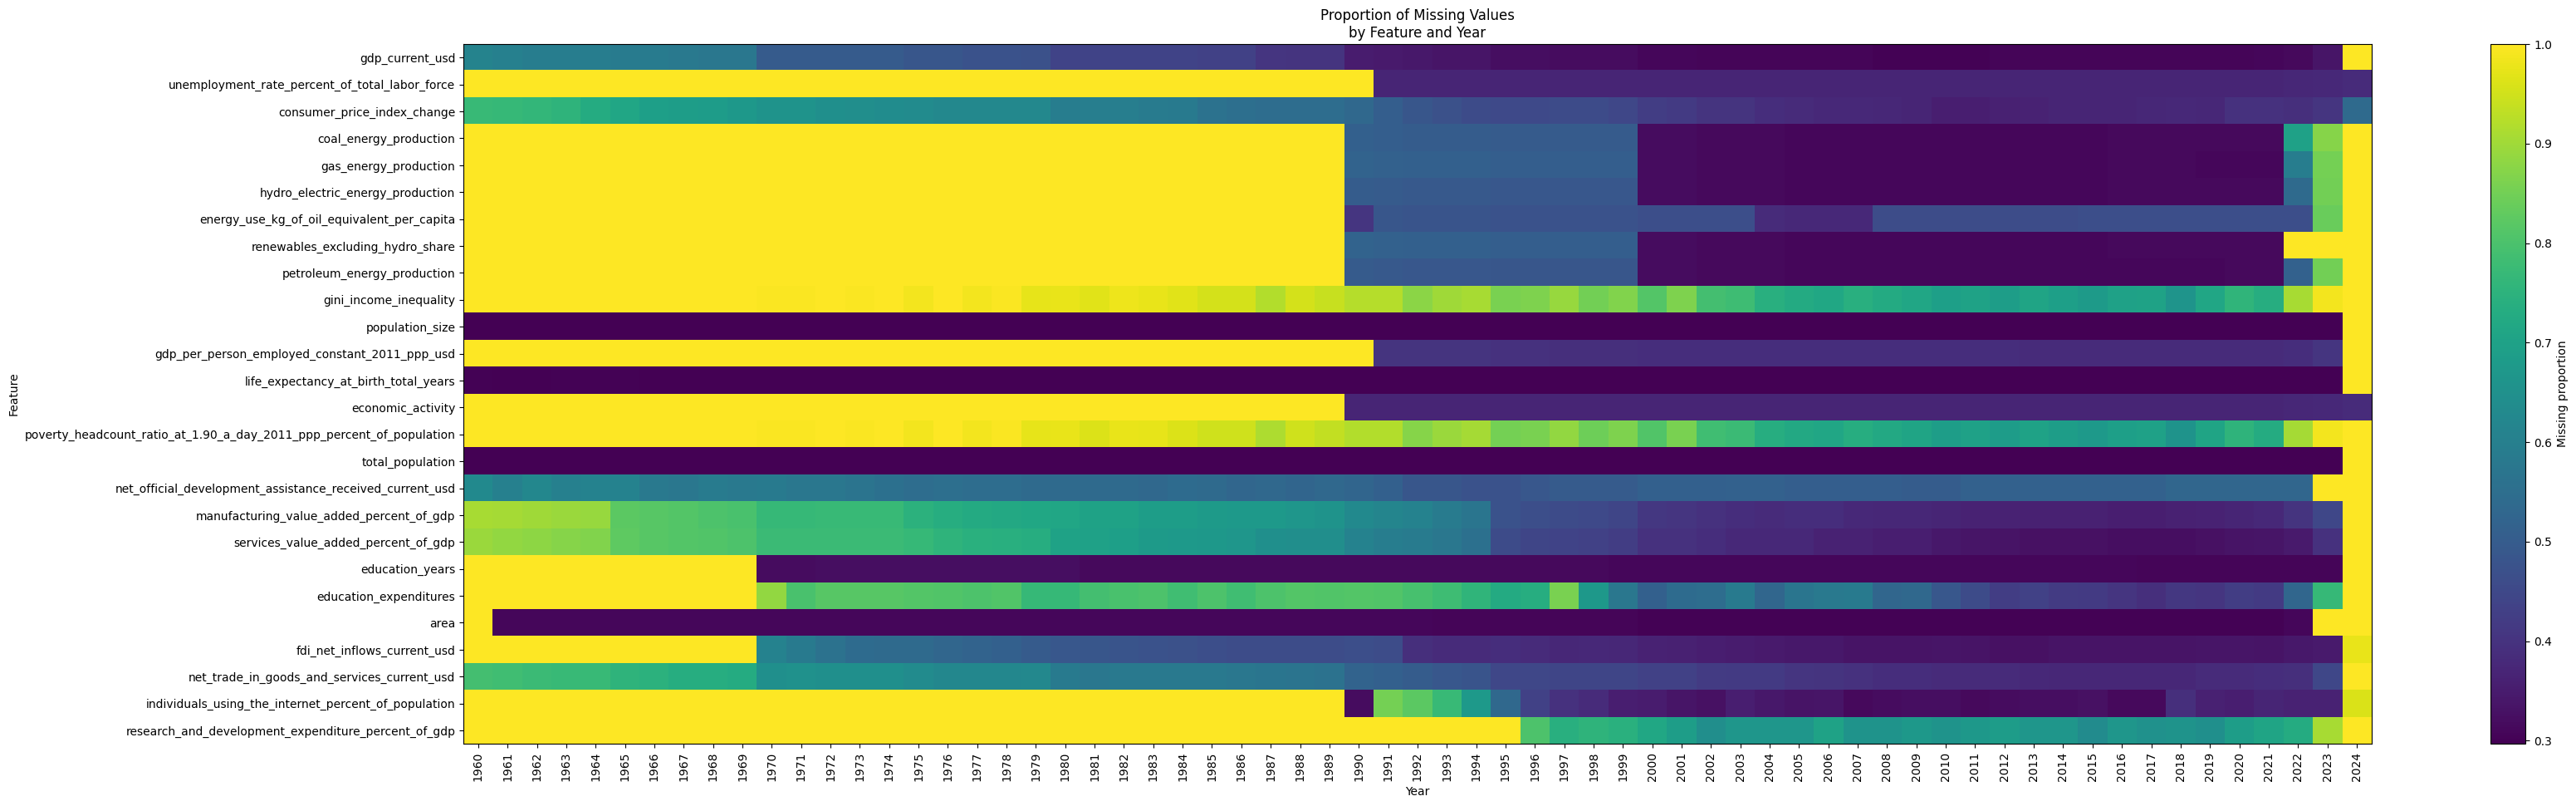

In [6]:
hm = compute_feature_yearly_missing(datadict)

plot_feature_missing_heatmap(hm)


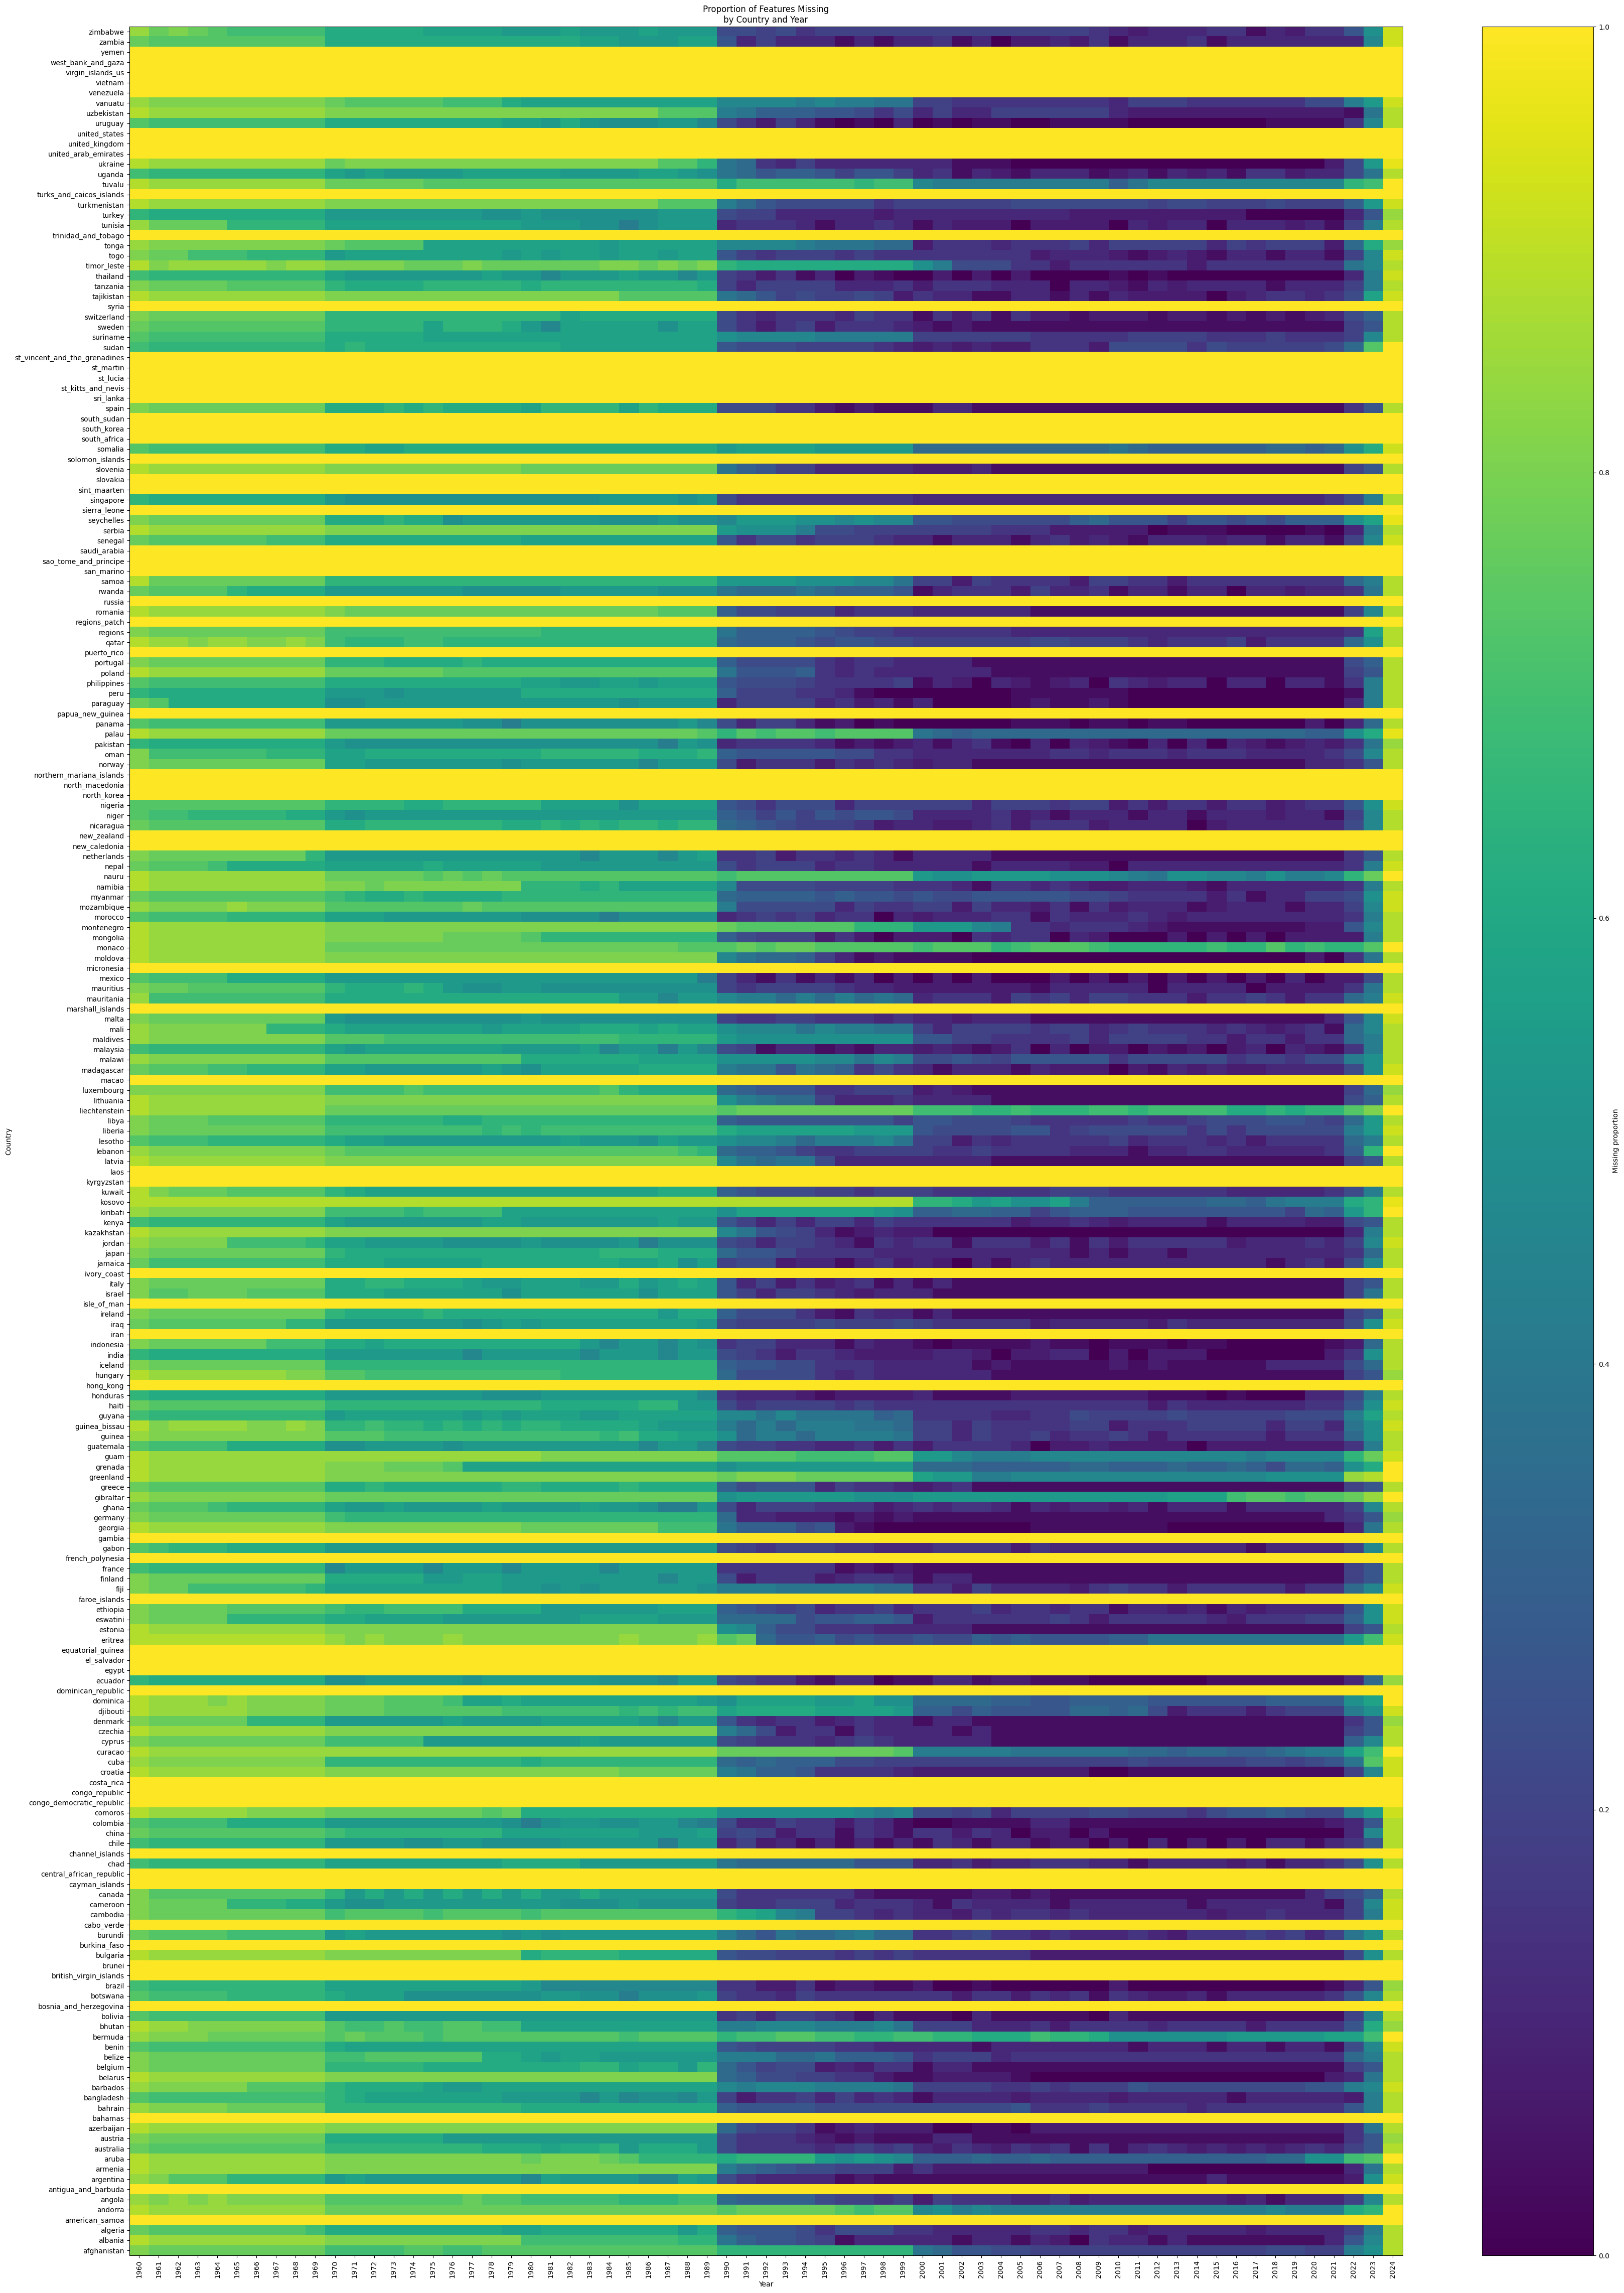

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

def compute_country_yearly_missing(
    datadict: Dict[str, pd.DataFrame]
) -> pd.DataFrame:
    """
    Returns a DataFrame C with
      – index = country names
      – columns = sorted years (ints)
      – C.loc[c, y] = proportion of features that are missing
                     for country c in year y.
    """
    # 1) for each feature, build a years×countries %‐missing matrix
    per_feature = []
    for df in datadict.values():
        df2 = df.copy()
        # ensure datetime index
        if not pd.api.types.is_datetime64_any_dtype(df2.index):
            try:
                df2.index = pd.to_datetime(df2.index, format="%Y")
            except:
                df2.index = pd.to_datetime(df2.index)
        # boolean missing flags
        missing = df2.isna()
        # group by calendar‐year, then mean over rows → proportion missing *per country* each year
        yearly = missing.groupby(df2.index.year).mean()
        per_feature.append(yearly)

    # 2) stack them: sum then divide by number of features → years×countries
    total = sum(per_feature)
    avg    = total / len(per_feature)

    # 3) transpose → countries×years
    heatmap = avg.T

    # 4) re‐order rows & columns
    years     = sorted(avg.index)
    countries = sorted(heatmap.index)
    heatmap   = heatmap.loc[countries, years]

    return heatmap


def plot_country_missing_heatmap(heatmap: pd.DataFrame):
    """
    Given the DataFrame from compute_country_yearly_missing,
    plots a heatmap with
      – x axis = year
      – y axis = country
      – color = proportion of features missing
    """
    plt.figure(
        figsize=(
            len(heatmap.columns) * 0.5 + 2,
            len(heatmap.index)   * 0.2 + 2
        )
    )
    data = heatmap.values.astype(float)
    img  = plt.imshow(data, aspect="auto", origin="lower")
    plt.xticks(
        np.arange(len(heatmap.columns)),
        heatmap.columns,
        rotation=90
    )
    plt.yticks(
        np.arange(len(heatmap.index)),
        heatmap.index
    )
    plt.xlabel("Year")
    plt.ylabel("Country")
    plt.title("Proportion of Features Missing\nby Country and Year")
    plt.colorbar(img, label="Missing proportion")
    plt.tight_layout()
    plt.show()


cty_hm = compute_country_yearly_missing(datadict)
plot_country_missing_heatmap(cty_hm)
